# Time-Series Forecasting of Carbon Monoxide and Nitrogen Dioxide Levels

In [1]:
## Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
## Loading the Dataset
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/airquality.csv'
df = pd.read_csv(url)

# Display the first few rows
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [3]:
## Data Preprocessing
# Combine 'Date' and 'Time' into a single datetime column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Set 'datetime' as the index
df.set_index('datetime', inplace=True)

# Drop redundant columns
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Resample to daily averages
df_daily = df.resample('D').mean()

# Handle missing values using forward fill
df_daily.fillna(method='ffill', inplace=True)

# Display the processed data
df_daily.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,,,,,
2004-03-10,1.966667,1316.500000,86.500000,8.450000,912.333333,132.000000,1167.333333,108.833333,1545.500000,1096.000000,12.033333,54.900000,0.765633
2004-03-11,-6.187500,1244.166667,104.500000,7.979167,851.958333,130.041667,1277.250000,87.375000,1522.833333,885.250000,9.837500,64.075000,0.775767
2004-03-12,-14.095833,1281.666667,141.500000,12.129167,1008.291667,142.583333,1101.875000,89.916667,1627.291667,1084.375000,11.287500,51.095833,0.663104
2004-03-13,-5.750000,1330.666667,139.250000,10.916667,992.833333,168.416667,993.208333,105.583333,1595.791667,1245.916667,12.866667,51.533333,0.732296
2004-03-14,-5.966667,1361.125000,116.958333,9.637500,943.916667,132.166667,1001.291667,97.458333,1602.375000,1234.208333,16.012500,48.850000,0.849671


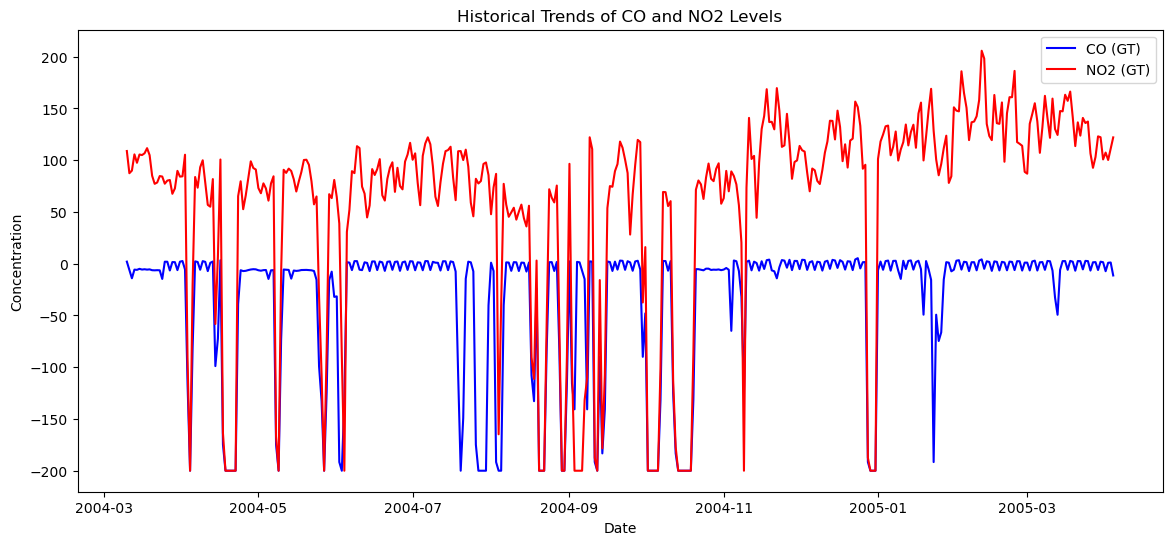

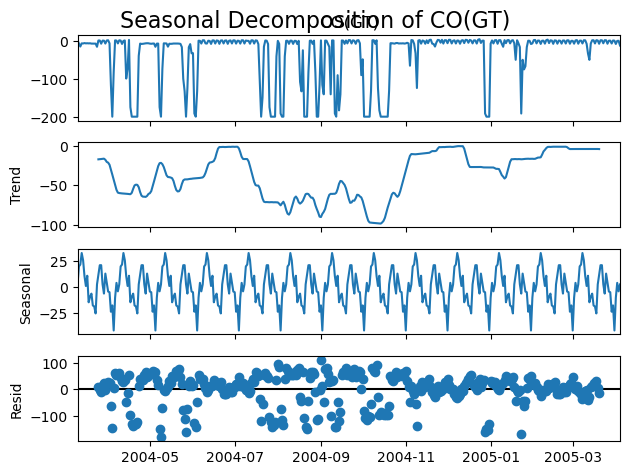

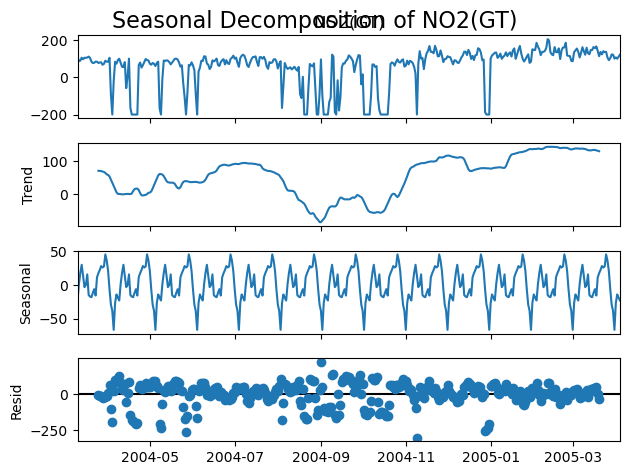

In [4]:
## Exploratory Data Analysis (EDA)
# Visualize historical trends of CO(GT) and NO2(GT)
plt.figure(figsize=(14, 6))
plt.plot(df_daily['CO(GT)'], label='CO (GT)', color='blue')
plt.plot(df_daily['NO2(GT)'], label='NO2 (GT)', color='red')
plt.title('Historical Trends of CO and NO2 Levels')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# Seasonal decomposition
result_co = seasonal_decompose(df_daily['CO(GT)'], model='additive', period=30)
result_no2 = seasonal_decompose(df_daily['NO2(GT)'], model='additive', period=30)

# Plot seasonal decomposition for CO(GT)
result_co.plot()
plt.suptitle('Seasonal Decomposition of CO(GT)', fontsize=16)
plt.show()

# Plot seasonal decomposition for NO2(GT)
result_no2.plot()
plt.suptitle('Seasonal Decomposition of NO2(GT)', fontsize=16)
plt.show()

In [5]:
## Feature Engineering
# Lag features
df_daily['CO_lag1'] = df_daily['CO(GT)'].shift(1)
df_daily['NO2_lag1'] = df_daily['NO2(GT)'].shift(1)

# Time-based features
df_daily['day_of_week'] = df_daily.index.dayofweek
df_daily['month'] = df_daily.index.month

# Drop rows with NaN values after feature engineering
df_daily.dropna(inplace=True)

In [6]:
## Train-Test Split
# Define target variables and features
X_co = df_daily[['CO_lag1', 'day_of_week', 'month']]
y_co = df_daily['CO(GT)']

X_no2 = df_daily[['NO2_lag1', 'day_of_week', 'month']]
y_no2 = df_daily['NO2(GT)']

# Split the data into train and test sets
X_co_train, X_co_test, y_co_train, y_co_test = train_test_split(X_co, y_co, test_size=0.2, random_state=42)
X_no2_train, X_no2_test, y_no2_train, y_no2_test = train_test_split(X_no2, y_no2, test_size=0.2, random_state=42)

In [7]:
## Model Training and Forecasting
# ARIMA Model for CO(GT)
model_arima_co = ARIMA(y_co_train, order=(5, 1, 0))
results_arima_co = model_arima_co.fit()

# Forecasting with ARIMA
forecast_co = results_arima_co.forecast(steps=len(y_co_test))

# Evaluate ARIMA Model
mae_co = mean_absolute_error(y_co_test, forecast_co)
rmse_co = np.sqrt(mean_squared_error(y_co_test, forecast_co))
print(f"ARIMA CO(GT) - MAE: {mae_co}, RMSE: {rmse_co}")

# LSTM Model for NO2(GT)
# Reshape data for LSTM input
X_no2_train_lstm = np.array(X_no2_train).reshape((X_no2_train.shape[0], X_no2_train.shape[1], 1))
X_no2_test_lstm = np.array(X_no2_test).reshape((X_no2_test.shape[0], X_no2_test.shape[1], 1))

# Build LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_no2_train_lstm.shape[1], 1)),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
lstm_model.fit(X_no2_train_lstm, y_no2_train, epochs=20, batch_size=32, verbose=0)

# Forecasting with LSTM
forecast_no2 = lstm_model.predict(X_no2_test_lstm)

# Evaluate LSTM Model
mae_no2 = mean_absolute_error(y_no2_test, forecast_no2)
rmse_no2 = np.sqrt(mean_squared_error(y_no2_test, forecast_no2))
print(f"LSTM NO2(GT) - MAE: {mae_no2}, RMSE: {rmse_no2}")

ARIMA CO(GT) - MAE: 33.72527176692389, RMSE: 69.33932626048905
3/3 [==============================] - 0s 4ms/step
LSTM NO2(GT) - MAE: 28.805615584055584, RMSE: 45.09504875421901


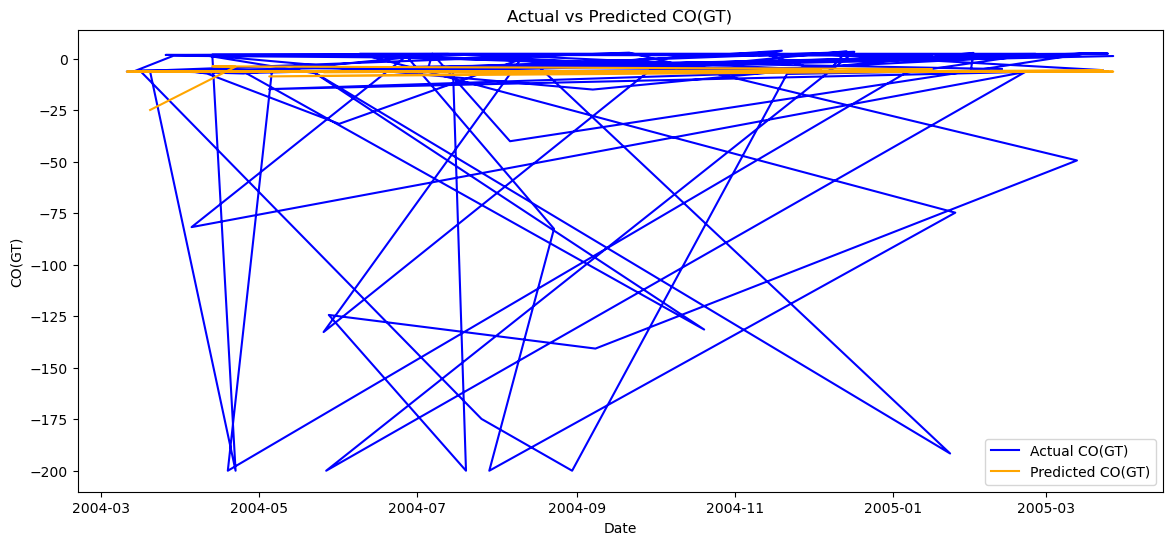

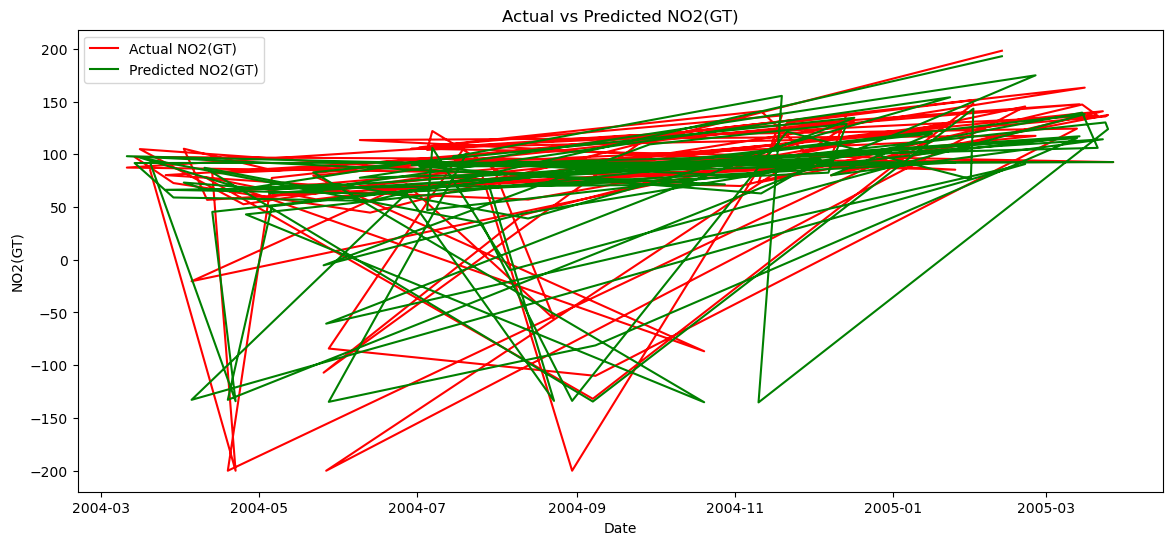

In [8]:
## Visualization of Forecasts
# Plot actual vs. predicted values for CO(GT)
plt.figure(figsize=(14, 6))
plt.plot(y_co_test.index, y_co_test, label='Actual CO(GT)', color='blue')
plt.plot(y_co_test.index, forecast_co, label='Predicted CO(GT)', color='orange')
plt.title('Actual vs Predicted CO(GT)')
plt.xlabel('Date')
plt.ylabel('CO(GT)')
plt.legend()
plt.show()

# Plot actual vs. predicted values for NO2(GT)
plt.figure(figsize=(14, 6))
plt.plot(y_no2_test.index, y_no2_test, label='Actual NO2(GT)', color='red')
plt.plot(y_no2_test.index, forecast_no2, label='Predicted NO2(GT)', color='green')
plt.title('Actual vs Predicted NO2(GT)')
plt.xlabel('Date')
plt.ylabel('NO2(GT)')
plt.legend()
plt.show()

In [9]:
## Insights and Recommendations
# Print insights and suggestions for mitigating high levels of CO and NO2
print("\nInsights:")
print("1. Seasonal trends show higher levels during specific months; targeted interventions can be implemented during these periods.")
print("2. External factors like temperature and humidity play a role in pollutant levels.")
print("3. Predicted high pollution days can help policymakers take preemptive actions like traffic restrictions or industrial regulation.")


Insights:
1. Seasonal trends show higher levels during specific months; targeted interventions can be implemented during these periods.
2. External factors like temperature and humidity play a role in pollutant levels.
3. Predicted high pollution days can help policymakers take preemptive actions like traffic restrictions or industrial regulation.
